In [33]:
import numpy as np
import pandas as pd
train = pd.read_csv('../input/train.csv')
train = train[train['mr_low']>0]
def format_(dataframe, feature, fillna='0.0', astype=np.float32, normalize=True):
    print('format', feature)
    dataframe[feature] = dataframe[feature].fillna(fillna)
    dataframe[feature] = dataframe[feature].astype(np.float32)
    if normalize:
        dataframe.loc[dataframe[feature]>1, feature] = 1
        dataframe.loc[dataframe[feature]<0, feature] = 0
    return dataframe
from sklearn.preprocessing import MinMaxScaler
def normalized_feature(dataframe, feature):
    print('start scale', feature)
    mms = MinMaxScaler()
    return mms.fit_transform(dataframe[feature].values.reshape(-1, 1))
# rate 1
posi_f = [
    'voice_connection', 'wifi_connection',
    'voice_convert_1', 'convert_rate',
    'rrc_connection',
    'esrvcc_convert'
]

# rate 0
navg_f = [
    'voice_disconnection', 'wifi_disconnection',
    'wifi_disconnection_1',
     'prb_pull', 'prb_push'
]

# count 
count_f = [
    'voice_pull_delay','voice_count', 'data_count', 
    'rrc_max', 'csgb_rrc', 'rrc_2g', 'rrc_3g', 'rrc_num',
    'voice_push_miss', 'voice_pull_miss'
]

# drop
drop_f = [
    'video_connection', 'video_disconnection', 'voice_convert_2', 'voice_convert_2', 'pdcch_cce'
]
    
for feature in posi_f:
    train = format_(train, feature, fillna=train[feature].mean())
    
for feature in navg_f:
    train = format_(train, feature, fillna=train[feature].mean())
    
for feature in count_f:
    train = format_(train, feature, fillna=train[feature].mean(), normalize=False)
    train[feature] = normalized_feature(train, feature)
    
train = train.drop(drop_f, axis=1)
train.mr_low = train.mr_low.astype(np.float32)
train.mr_high = train.mr_high.astype(np.float32)
# train['MCC'] = train['cgi'].apply(lambda x: str(x).split('-')[0])
# train['MNC'] = train['cgi'].apply(lambda x: str(x).split('-')[1])
train['ENODEB_ID'] = train['cgi'].apply(lambda x: str(x).split('-')[2])
train['CID'] = train['cgi'].apply(lambda x: str(x).split('-')[3])
train['ENODEB_ID'] = train['ENODEB_ID'].astype(np.int32)
train['CID'] = train['CID'].astype(np.int32)
train['datetime'] = train['time'].apply(lambda x: str(x).split(' ')[0])

# train['month'] = pd.to_datetime(train['time']).dt.month
# train['day'] = pd.to_datetime(train['time']).dt.day
train['hour'] = pd.to_datetime(train['time']).dt.hour
from sklearn.preprocessing import LabelEncoder
train['region'] = LabelEncoder().fit_transform(train['region'])
train = train.drop(['city', 'cgi', 'time'], axis=1)
num_f = posi_f + navg_f + count_f
cat_f = [
    'region', 'ENODEB_ID', 'CID', 'hour'
]
test_set = train[train.loc[:,('datetime')]=='2018-05-06']
train_set = train[train.loc[:,('datetime')]=='2018-05-05']
train_set = pd.concat([train_set, train[train.loc[:,('datetime')]=='2018-05-04']])
train_set = pd.concat([train_set, train[train.loc[:,('datetime')]=='2018-05-03']])
train_set = pd.concat([train_set, train[train.loc[:,('datetime')]=='2018-05-02']])
train_set = pd.concat([train_set, train[train.loc[:,('datetime')]=='2018-05-01']])
train_set = pd.concat([train_set, train[train.loc[:,('datetime')]=='2018-04-30']])
test_set = test_set.drop(['datetime'], axis=1)
train_set = train_set.drop(['datetime'], axis=1)
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import gc
test_y_low = test_set['mr_low']
test_y_high = test_set['mr_high']
test_x = test_set.drop(['mr_low', 'mr_high'], axis=1)
train_y_low = train_set['mr_low']
train_y_high = train_set['mr_high']
train_x = train_set.drop(['mr_low', 'mr_high'], axis=1)
trainx, validx, trainy, validy = train_test_split(
    train_x, 
    train_y_low, 
    test_size=0.1, 
    random_state=432423
)
import gc
del train
del train_set
del test_set
gc.collect()

format voice_connection
format wifi_connection
format voice_convert_1
format convert_rate
format rrc_connection
format esrvcc_convert
format voice_disconnection
format wifi_disconnection
format wifi_disconnection_1
format prb_pull
format prb_push
format voice_pull_delay
start scale voice_pull_delay
format voice_count
start scale voice_count
format data_count
start scale data_count
format rrc_max
start scale rrc_max
format csgb_rrc
start scale csgb_rrc
format rrc_2g
start scale rrc_2g
format rrc_3g
start scale rrc_3g
format rrc_num
start scale rrc_num
format voice_push_miss
start scale voice_push_miss
format voice_pull_miss
start scale voice_pull_miss


168

# 全数据

In [21]:
train_data = lgb.Dataset(trainx, trainy, categorical_feature=cat_f)
valid_data = lgb.Dataset(validx, validy, categorical_feature=cat_f)

params = {
#     'application': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 80,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'zero_as_missing': True,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'metric':{'mse'}
}

model = lgb.train(
    params, train_data, 2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    verbose_eval=50,
    early_stopping_rounds=100
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[50]	train's l2: 0.00358016	valid's l2: 0.0036287
[100]	train's l2: 0.0029655	valid's l2: 0.00306379
[150]	train's l2: 0.002662	valid's l2: 0.00279206
[200]	train's l2: 0.0024939	valid's l2: 0.00265134
[250]	train's l2: 0.00238151	valid's l2: 0.00256343
[300]	train's l2: 0.00229872	valid's l2: 0.00250339
[350]	train's l2: 0.00223018	valid's l2: 0.00245612
[400]	train's l2: 0.00217697	valid's l2: 0.00241897
[450]	train's l2: 0.00212779	valid's l2: 0.00238466
[500]	train's l2: 0.00208347	valid's l2: 0.00235673
[550]	train's l2: 0.00204604	valid's l2: 0.00233199
[600]	train's l2: 0.00201433	valid's l2: 0.00231304
[650]	train's l2: 0.0019858	valid's l2: 0.00229693
[700]	train's l2: 0.00195957	valid's l2: 0.00228233
[750]	train's l2: 0.00193341	valid's l2: 0.00226861
[800]	train's l2: 0.00190938	valid's l2: 0.00225624
[850]	train's l2: 0.00188703	valid's l2: 0.00224567
[900]	train's l2: 0.00186699	valid's l2: 0.00223589
[950]	tr

In [22]:
pre = model.predict(test_x)


In [23]:
from sklearn import metrics
valid_auc = metrics.mean_squared_error(test_y_low, pre)
print(valid_auc)


0.002262706741885007


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns # for making plots with seaborn
def draw(real, pre, skip=0, n=10):
    al = []
    for i in range(n):
        al.append(i)

    ax1 = plt.subplot(221)
    ax1.set_title('pre')   
    ax1.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax1.legend(bbox_to_anchor=[1, 1])  
    ax1.grid() 

    ax2 = plt.subplot(222)
    ax2.set_title('real')   
    ax2.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax2.legend(bbox_to_anchor=[1, 1])  
    ax2.grid() 

    ax3 = plt.subplot(212)
    ax3.set_title('pre & real')   
    ax3.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax3.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax3.legend(bbox_to_anchor=[1, 1])  
    ax3.grid() 

    plt.show()
    

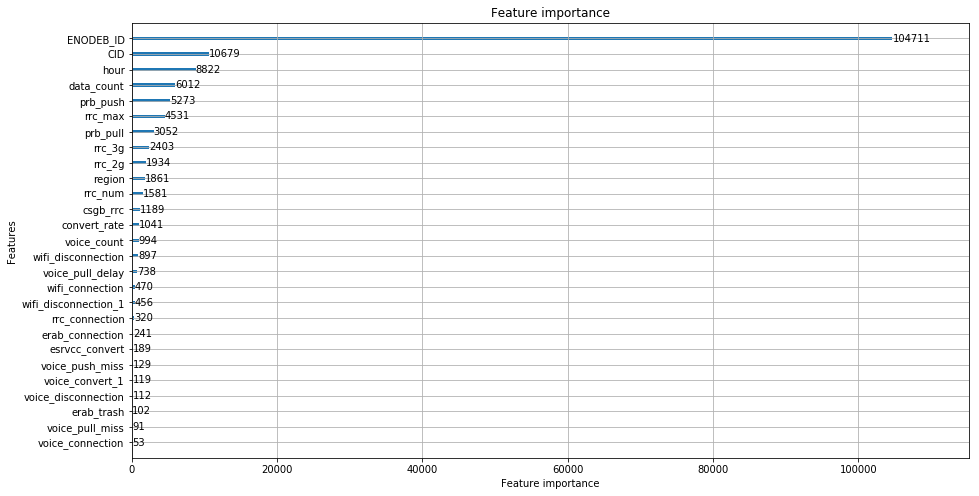

In [28]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
lgb.plot_importance(booster=model)

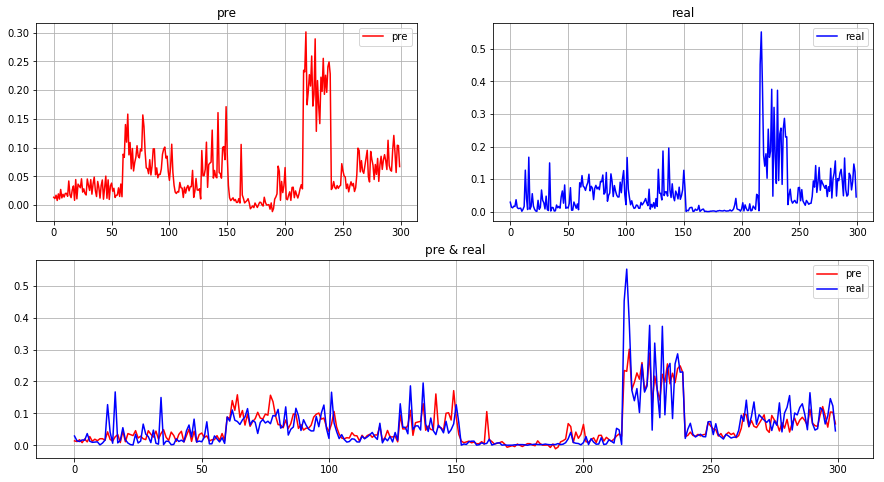

In [29]:
draw(test_y_low, pre, skip=226, n=300)


*	应用层数据：数据业务量GB
	网元数据：上行PRB平均利用率，有效RRC连接最大数，RRC连接最大数， ERAB拥塞率
	结果拟合较好，下一步可以做用应用层数据替换网元数据的实验
*	应用层数据：无线接通率
	网元数据：ERAB建立成功率，ERAB拥塞率，RRC连接建立成功率
	结果基本重合，可以替换
*	应用层数据：无线掉线率
	网元数据：ERAB建立成功率，ERAB拥塞率
	可以做替换实验


# 第一组

In [21]:
train_data = lgb.Dataset(trainx, trainy, categorical_feature=cat_f)
valid_data = lgb.Dataset(validx, validy, categorical_feature=cat_f)

params = {
#     'application': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 80,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'zero_as_missing': True,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'metric':{'mse'}
}

model = lgb.train(
    params, train_data, 2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    verbose_eval=50,
    early_stopping_rounds=100
)
pre = model.predict(test_x)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[50]	train's l2: 0.00356967	valid's l2: 0.00361917
[100]	train's l2: 0.00297106	valid's l2: 0.00306986
[150]	train's l2: 0.00266528	valid's l2: 0.00279255
[200]	train's l2: 0.00249373	valid's l2: 0.00264873
[250]	train's l2: 0.00237865	valid's l2: 0.00255857
[300]	train's l2: 0.00229645	valid's l2: 0.00249861
[350]	train's l2: 0.00222915	valid's l2: 0.00244956
[400]	train's l2: 0.0021726	valid's l2: 0.00240913
[450]	train's l2: 0.00212447	valid's l2: 0.0023767
[500]	train's l2: 0.00208455	valid's l2: 0.00235011
[550]	train's l2: 0.00204918	valid's l2: 0.00232777
[600]	train's l2: 0.00201817	valid's l2: 0.00230921
[650]	train's l2: 0.00198923	valid's l2: 0.00229337
[700]	train's l2: 0.00196297	valid's l2: 0.00227846
[750]	train's l2: 0.00193943	valid's l2: 0.0022665
[800]	train's l2: 0.00191594	valid's l2: 0.0022547
[850]	train's l2: 0.00189465	valid's l2: 0.0022454
[900]	train's l2: 0.00187274	valid's l2: 0.00223604
[950]	t

In [22]:
from sklearn import metrics
valid_auc = metrics.mean_squared_error(test_y_low, pre)
print(valid_auc)


0.0022569148836077374


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns # for making plots with seaborn
def draw(real, pre, skip=0, n=10):
    al = []
    for i in range(n):
        al.append(i)

    ax1 = plt.subplot(221)
    ax1.set_title('pre')   
    ax1.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax1.legend(bbox_to_anchor=[1, 1])  
    ax1.grid() 

    ax2 = plt.subplot(222)
    ax2.set_title('real')   
    ax2.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax2.legend(bbox_to_anchor=[1, 1])  
    ax2.grid() 

    ax3 = plt.subplot(212)
    ax3.set_title('pre & real')   
    ax3.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax3.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax3.legend(bbox_to_anchor=[1, 1])  
    ax3.grid() 

    plt.show()
    

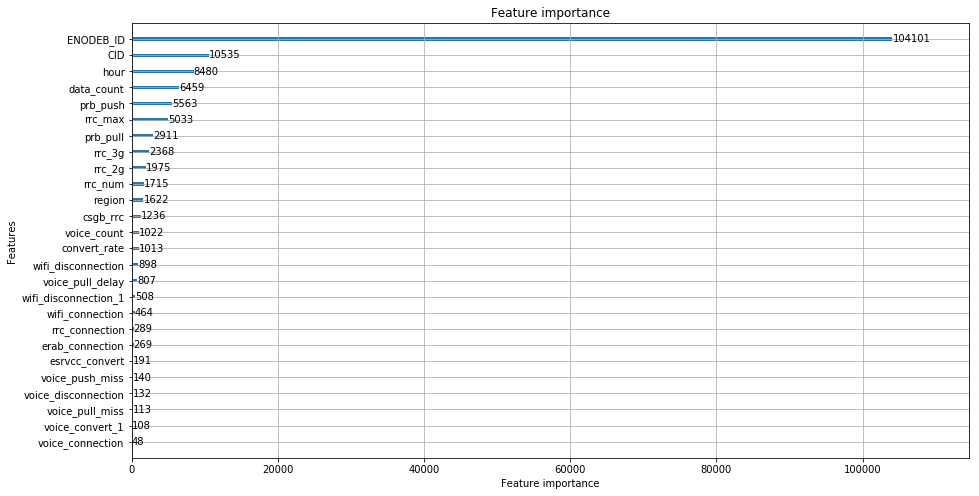

In [24]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
lgb.plot_importance(booster=model)

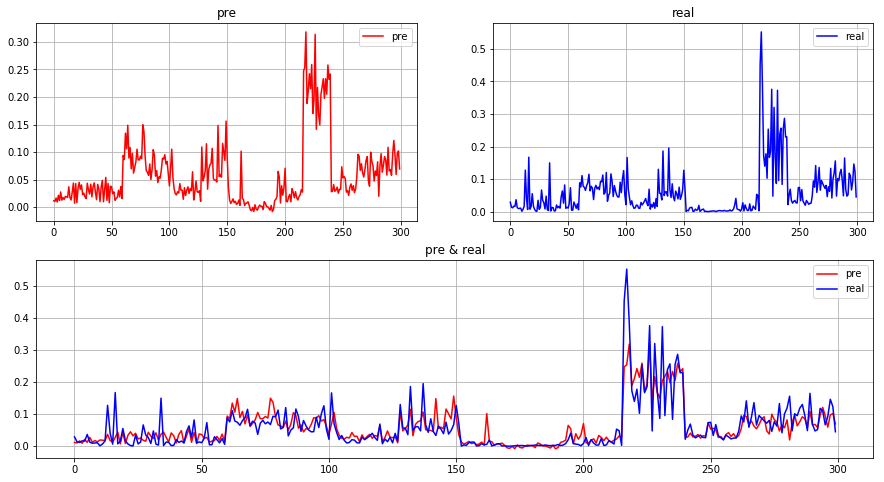

In [25]:
draw(test_y_low, pre, skip=226, n=300)


# 第二组

In [28]:
train_data = lgb.Dataset(trainx, trainy, categorical_feature=cat_f)
valid_data = lgb.Dataset(validx, validy, categorical_feature=cat_f)

params = {
#     'application': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 80,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'zero_as_missing': True,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'metric':{'mse'}
}

model = lgb.train(
    params, train_data, 2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    verbose_eval=50,
    early_stopping_rounds=100
)
pre = model.predict(test_x)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[50]	train's l2: 0.00358497	valid's l2: 0.00363391
[100]	train's l2: 0.00297553	valid's l2: 0.00307241
[150]	train's l2: 0.00267159	valid's l2: 0.0028004
[200]	train's l2: 0.00249778	valid's l2: 0.00265358
[250]	train's l2: 0.00238588	valid's l2: 0.00256516
[300]	train's l2: 0.00230341	valid's l2: 0.0025031
[350]	train's l2: 0.00223264	valid's l2: 0.00245266
[400]	train's l2: 0.00217825	valid's l2: 0.00241517
[450]	train's l2: 0.00212829	valid's l2: 0.0023799
[500]	train's l2: 0.00208562	valid's l2: 0.00235351
[550]	train's l2: 0.00204949	valid's l2: 0.00233217
[600]	train's l2: 0.00201777	valid's l2: 0.00231387
[650]	train's l2: 0.00198717	valid's l2: 0.00229635
[700]	train's l2: 0.00195975	valid's l2: 0.00228168
[750]	train's l2: 0.00193323	valid's l2: 0.00226787
[800]	train's l2: 0.00190988	valid's l2: 0.00225658
[850]	train's l2: 0.00188807	valid's l2: 0.00224558
[900]	train's l2: 0.00186709	valid's l2: 0.0022362
[950]	

In [29]:
from sklearn import metrics
valid_auc = metrics.mean_squared_error(test_y_low, pre)
print(valid_auc)


0.0022632097385325047


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns # for making plots with seaborn
def draw(real, pre, skip=0, n=10):
    al = []
    for i in range(n):
        al.append(i)

    ax1 = plt.subplot(221)
    ax1.set_title('pre')   
    ax1.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax1.legend(bbox_to_anchor=[1, 1])  
    ax1.grid() 

    ax2 = plt.subplot(222)
    ax2.set_title('real')   
    ax2.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax2.legend(bbox_to_anchor=[1, 1])  
    ax2.grid() 

    ax3 = plt.subplot(212)
    ax3.set_title('pre & real')   
    ax3.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax3.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax3.legend(bbox_to_anchor=[1, 1])  
    ax3.grid() 

    plt.show()
    

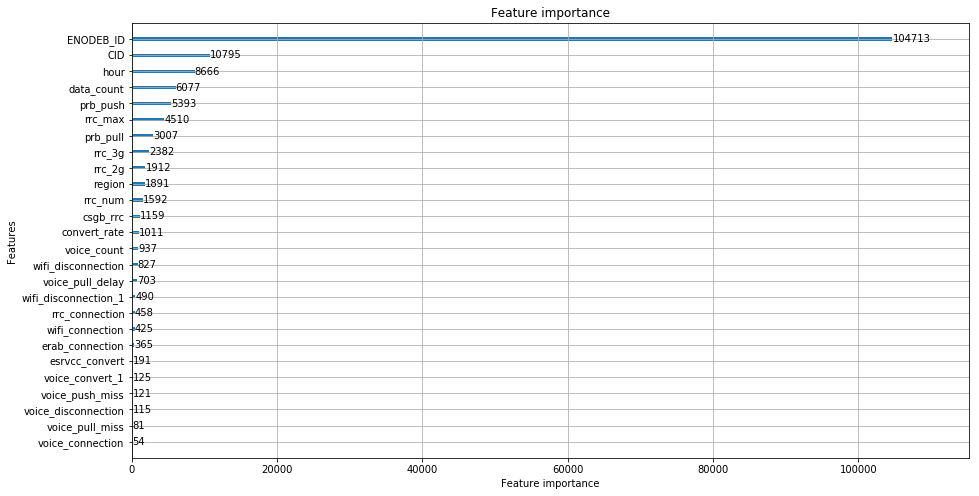

In [31]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
lgb.plot_importance(booster=model)

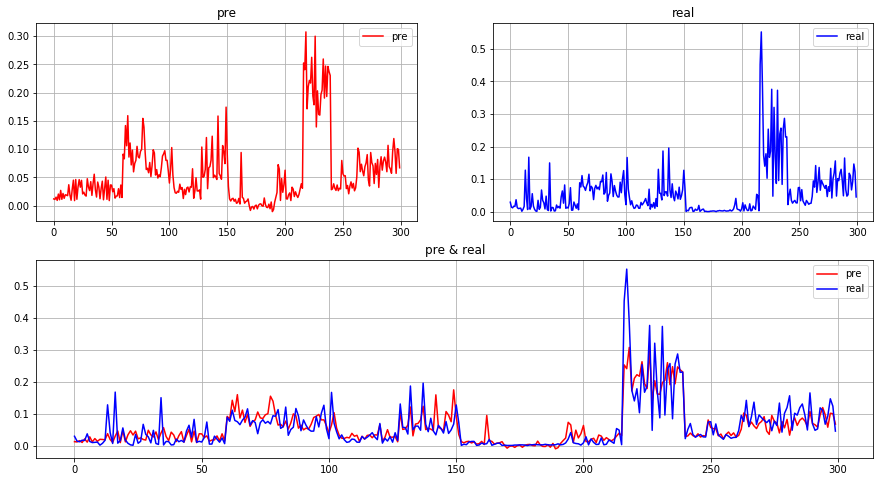

In [32]:
draw(test_y_low, pre, skip=226, n=300)


# 第三组

In [34]:
train_data = lgb.Dataset(trainx, trainy, categorical_feature=cat_f)
valid_data = lgb.Dataset(validx, validy, categorical_feature=cat_f)

params = {
#     'application': 'binary',
    'boosting': 'gbdt',
    'num_leaves': 80,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'zero_as_missing': True,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'metric':{'mse'}
}

model = lgb.train(
    params, train_data, 2000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    verbose_eval=50,
    early_stopping_rounds=100
)
pre = model.predict(test_x)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 100 rounds.
[50]	train's l2: 0.00357916	valid's l2: 0.00362826
[100]	train's l2: 0.0029689	valid's l2: 0.00306518
[150]	train's l2: 0.00267022	valid's l2: 0.00279674
[200]	train's l2: 0.0024957	valid's l2: 0.00265369
[250]	train's l2: 0.00238414	valid's l2: 0.00256495
[300]	train's l2: 0.00230027	valid's l2: 0.00250379
[350]	train's l2: 0.00223243	valid's l2: 0.00245478
[400]	train's l2: 0.00217749	valid's l2: 0.00241725
[450]	train's l2: 0.00212903	valid's l2: 0.00238422
[500]	train's l2: 0.0020851	valid's l2: 0.0023567
[550]	train's l2: 0.00205022	valid's l2: 0.00233482
[600]	train's l2: 0.00201901	valid's l2: 0.00231672
[650]	train's l2: 0.00198827	valid's l2: 0.00229956
[700]	train's l2: 0.00196069	valid's l2: 0.00228475
[750]	train's l2: 0.00193517	valid's l2: 0.00227086
[800]	train's l2: 0.00191078	valid's l2: 0.00225883
[850]	train's l2: 0.00188707	valid's l2: 0.00224672
[900]	train's l2: 0.00186614	valid's l2: 0.00223671
[950]	

In [35]:
from sklearn import metrics
valid_auc = metrics.mean_squared_error(test_y_low, pre)
print(valid_auc)


0.0022667342451268037


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns # for making plots with seaborn
def draw(real, pre, skip=0, n=10):
    al = []
    for i in range(n):
        al.append(i)

    ax1 = plt.subplot(221)
    ax1.set_title('pre')   
    ax1.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax1.legend(bbox_to_anchor=[1, 1])  
    ax1.grid() 

    ax2 = plt.subplot(222)
    ax2.set_title('real')   
    ax2.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax2.legend(bbox_to_anchor=[1, 1])  
    ax2.grid() 

    ax3 = plt.subplot(212)
    ax3.set_title('pre & real')   
    ax3.plot(al, pre[skip:skip+n], 'r', label='pre')
    ax3.plot(al, real[skip:skip+n].tolist(), 'b', label='real')
    ax3.legend(bbox_to_anchor=[1, 1])  
    ax3.grid() 

    plt.show()
    

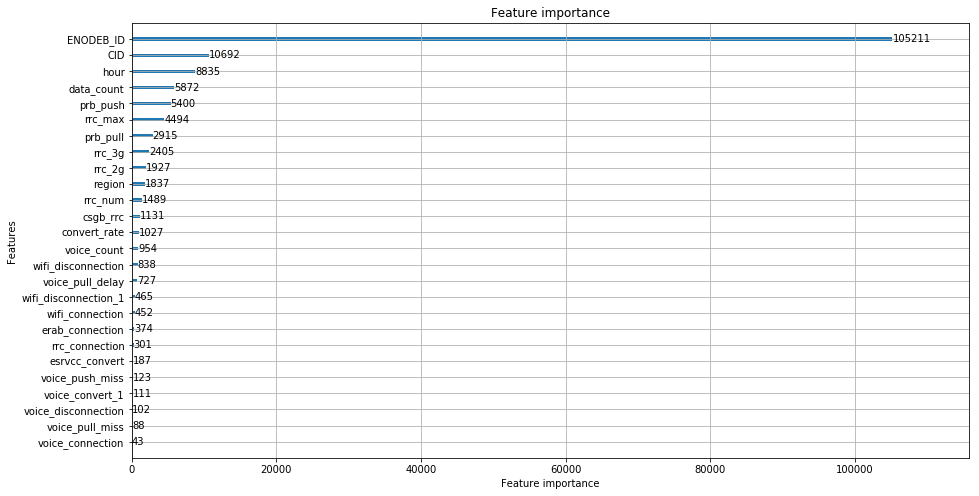

In [37]:
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
lgb.plot_importance(booster=model)

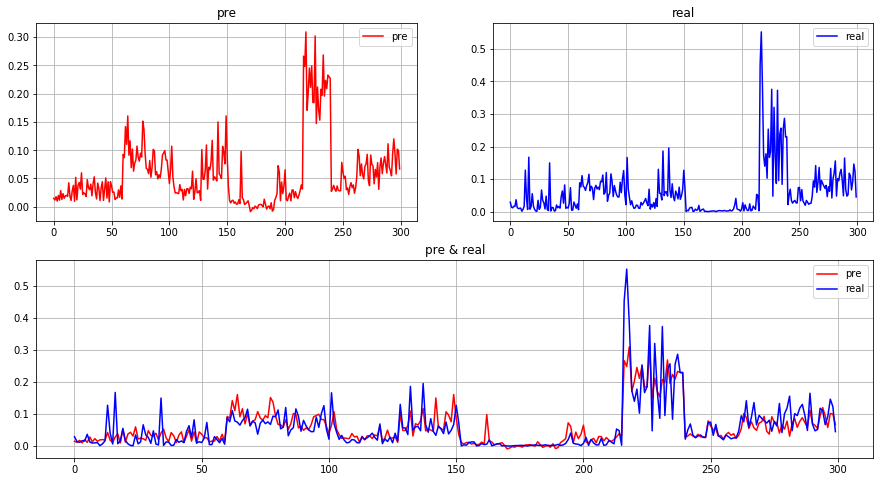

In [38]:
draw(test_y_low, pre, skip=226, n=300)
